In [49]:
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
from pathlib import Path
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error

In [50]:
def dbPath() -> Path:
    cwd = Path.cwd()
    dc2 = cwd.parent
    db = dc2.joinpath("data/database_final.db")
    return db

In [51]:
def modelPath(lsoaCode:str) ->Path:
    cwd = Path.cwd()
    dc2 = cwd.parent
    modelPath = dc2.joinpath(f"data/models/{lsoaCode}.bin")
    return modelPath

In [52]:
conn = sqlite3.connect(dbPath())
query_lsoa_codes = "SELECT geogcode FROM lsoa_code_to_name"
lsoa_codes = pd.read_sql(query_lsoa_codes, conn)

query_unemployement = "SELECT * FROM montly_unemployement_claimant_count_by_lsoa_barnet"
unemployement = pd.read_sql(query_unemployement, conn)

unemployement.dropna(inplace=True)
unemployement.drop(columns="index", inplace=True)
unemployement = unemployement[(unemployement["date"]<"2020") & (unemployement["date"]>"2012")]

unemployement = unemployement[unemployement["geogcode"]!="Column Total"].copy()

In [53]:
lsoa_code_list = lsoa_codes[lsoa_codes["geogcode"] != "Column Total"]["geogcode"].to_list()
lsoa_code_list

['E01000115',
 'E01000116',
 'E01000117',
 'E01000118',
 'E01000119',
 'E01000120',
 'E01000121',
 'E01000122',
 'E01000123',
 'E01000124',
 'E01000125',
 'E01000126',
 'E01000127',
 'E01000128',
 'E01000129',
 'E01000130',
 'E01000131',
 'E01000132',
 'E01000133',
 'E01000134',
 'E01000135',
 'E01000136',
 'E01000137',
 'E01000138',
 'E01000139',
 'E01000140',
 'E01000141',
 'E01000142',
 'E01000143',
 'E01000144',
 'E01000145',
 'E01000146',
 'E01000147',
 'E01000148',
 'E01000150',
 'E01000151',
 'E01000152',
 'E01000153',
 'E01000154',
 'E01000155',
 'E01000156',
 'E01000157',
 'E01000158',
 'E01000159',
 'E01000160',
 'E01000161',
 'E01000162',
 'E01000163',
 'E01000164',
 'E01000165',
 'E01000166',
 'E01000167',
 'E01000168',
 'E01000169',
 'E01000170',
 'E01000171',
 'E01000172',
 'E01000173',
 'E01000174',
 'E01000175',
 'E01000176',
 'E01000177',
 'E01000178',
 'E01000179',
 'E01000180',
 'E01000181',
 'E01000182',
 'E01000183',
 'E01000184',
 'E01000185',
 'E01000186',
 'E010

In [54]:
allFeatures = pd.DataFrame(columns=lsoa_code_list, index=unemployement["date"].unique())
allFeatures

,E01000115,E01000116,E01000117,E01000118,E01000119,E01000120,E01000121,E01000122,E01000123,E01000124,...,E01000317,E01000318,E01000319,E01000320,E01000321,E01000322,E01000323,E01000324,E01033572,E01033573
2013-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-02-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-03-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-05-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:

for row in tqdm(unemployement.index):
    allFeatures[unemployement["geogcode"][row]][unemployement["date"][row]] = unemployement["value"][row]

for code in tqdm(lsoa_code_list):
    for i in range(12):
        allFeatures[f"{code}_shift_{i+1}"] = allFeatures[f"{code}"].shift(i+1)

allFeatures = allFeatures.dropna()

code_out_shift = allFeatures[lsoa_code_list].copy()
code_with_shift = allFeatures.drop(lsoa_code_list, axis=True).copy()


  0%|          | 0/17724 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

/tmp/ipykernel_6864/2093186058.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  allFeatures[f"{code}_shift_{i+1}"] = allFeatures[f"{code}"].shift(i+1)
/tmp/ipykernel_6864/2093186058.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  allFeatures[f"{code}_shift_{i+1}"] = allFeatures[f"{code}"].shift(i+1)
/tmp/ipykernel_6864/2093186058.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using

In [56]:
allFeatures

,E01000115,E01000116,E01000117,E01000118,E01000119,E01000120,E01000121,E01000122,E01000123,E01000124,...,E01033573_shift_3,E01033573_shift_4,E01033573_shift_5,E01033573_shift_6,E01033573_shift_7,E01033573_shift_8,E01033573_shift_9,E01033573_shift_10,E01033573_shift_11,E01033573_shift_12
2014-01-01 00:00:00,10.0,15.0,20.0,20.0,15.0,15.0,35.0,15.0,20.0,45.0,...,35.0,35.0,35.0,40.0,35.0,30.0,30.0,30.0,30.0,25.0
2014-02-01 00:00:00,10.0,15.0,20.0,25.0,20.0,20.0,35.0,15.0,20.0,45.0,...,30.0,35.0,35.0,35.0,40.0,35.0,30.0,30.0,30.0,30.0
2014-03-01 00:00:00,10.0,10.0,15.0,20.0,15.0,15.0,35.0,15.0,25.0,40.0,...,30.0,30.0,35.0,35.0,35.0,40.0,35.0,30.0,30.0,30.0
2014-04-01 00:00:00,10.0,15.0,10.0,20.0,15.0,20.0,25.0,20.0,15.0,40.0,...,20.0,30.0,30.0,35.0,35.0,35.0,40.0,35.0,30.0,30.0
2014-05-01 00:00:00,10.0,15.0,15.0,20.0,10.0,20.0,30.0,15.0,15.0,45.0,...,25.0,20.0,30.0,30.0,35.0,35.0,35.0,40.0,35.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-01 00:00:00,10.0,10.0,15.0,20.0,10.0,10.0,30.0,10.0,20.0,45.0,...,40.0,30.0,30.0,30.0,35.0,35.0,25.0,30.0,30.0,25.0
2019-09-01 00:00:00,10.0,5.0,15.0,15.0,10.0,10.0,25.0,10.0,15.0,45.0,...,40.0,40.0,30.0,30.0,30.0,35.0,35.0,25.0,30.0,30.0
2019-10-01 00:00:00,10.0,5.0,15.0,20.0,15.0,15.0,30.0,10.0,15.0,45.0,...,40.0,40.0,40.0,30.0,30.0,30.0,35.0,35.0,25.0,30.0
2019-11-01 00:00:00,10.0,5.0,15.0,20.0,15.0,10.0,30.0,15.0,20.0,50.0,...,40.0,40.0,40.0,40.0,30.0,30.0,30.0,35.0,35.0,25.0


In [58]:
modelDct = {}
metrics = {
}
for col in tqdm(lsoa_code_list):
    y = code_out_shift[col].copy()
    x = code_with_shift.copy()
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    model = xgb.XGBRegressor()
    model.fit(X_train.values, y_train)
    y_pred = model.predict(X_test.values)
    mse_test = mean_squared_error(y_test, y_pred)
    mae_test = mean_absolute_error(y_test, y_pred)
    r2_test = r2_score(y_test, y_pred)
    medae_test = median_absolute_error(y_test, y_pred)
    metrics[col] = [mse_test, mae_test, r2_test, medae_test]
    model.save_model( modelPath(col))

  0%|          | 0/211 [00:00<?, ?it/s]

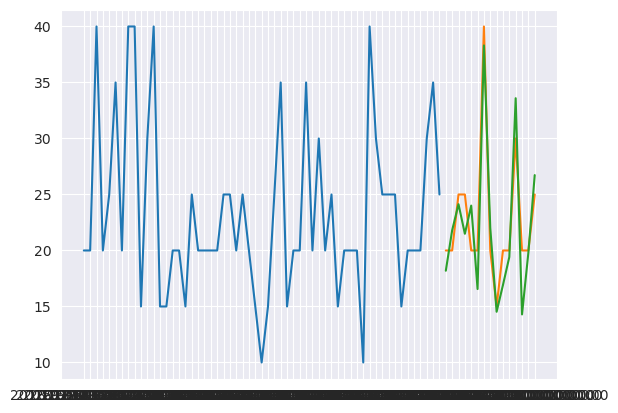

In [59]:
fig, ax = plt.subplots()

ax.plot(y_train.index, y_train)
ax.plot(y_test.index, y_test)
ax.plot(y_test.index, y_pred)


In [60]:
max_key = max(metrics, key=lambda k: metrics[k][0])

In [61]:
max_key

'E01000153'

KeyError: 'Column Total'

In [63]:
by_metric = {'MSE':[], 'MAE':[], 'R^2':[], "MedAE":[]}
for val in metrics.values():
    by_metric["MSE"].append(val[0])
    by_metric["MAE"].append(val[1])
    by_metric["R^2"].append(val[2])
    by_metric["MedAE"].append(val[3])

In [64]:
import seaborn as sns


In [65]:
metricDF = pd.DataFrame(by_metric)

<Axes: >

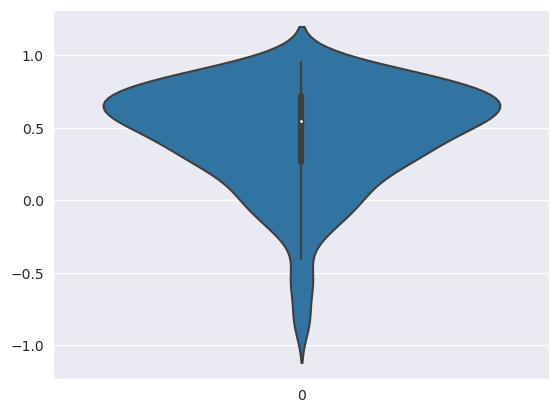

In [66]:
sns.violinplot(data=metricDF["R^2"])

<Axes: >

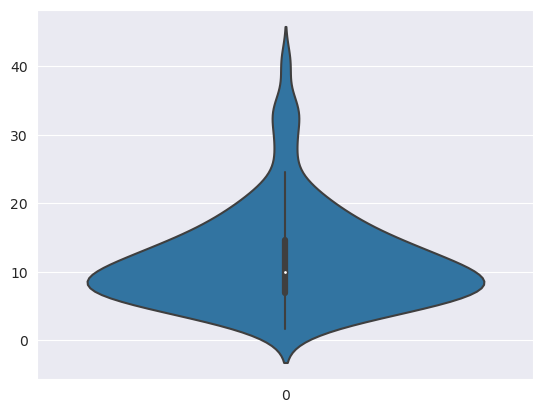

In [67]:
sns.violinplot(data=metricDF["MSE"])
